# Wavefront Propagation and PSF simulation with Scoob
The scoobPSF package builds a layer on-top of poppy that is specific to the scoob optical bench.
This notebook demonstrates how to simulate monochromatic PSFs and wavefronts with the scoobPSF package. <br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [8]:
reload(scoob)
model = scoob.SCOOBM()

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


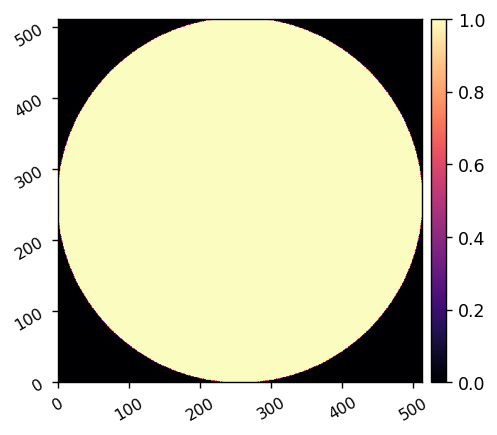

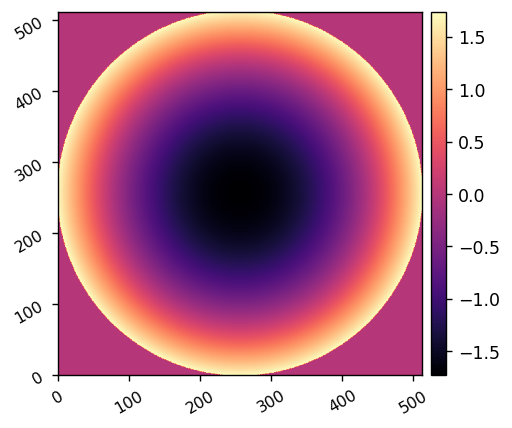

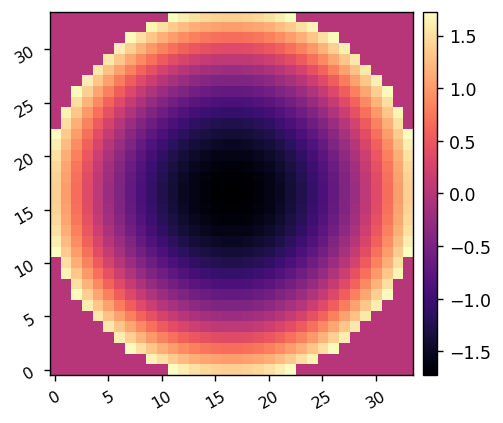

In [29]:
wf = poppy.Wavefront(diam=model.pupil_diam, npix=512, oversample=1)
pupil_mask = poppy.CircularAperture(radius=model.pupil_diam/2, name='Pupil').get_transmission(wf).astype(bool)
imshow1(pupil_mask)

reload(lina.llowfsc)
zmodes = lina.llowfsc.create_zernike_modes(pupil_mask, nmodes=15)[3:]
imshow1(zmodes[0])

dm_zernikes = lina.llowfsc.create_zernike_modes(model.dm_mask)[3:]
imshow1(dm_zernikes[0])


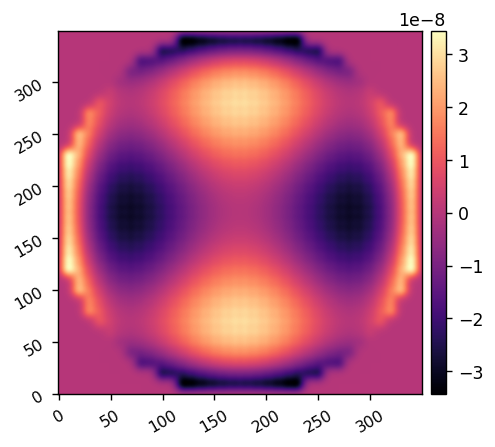

In [30]:
model.set_dm(dm_zernikes[8]*1e-8)
imshow1(model.DM.get_surface())

In [31]:
model.RETRIEVED.pixelscale

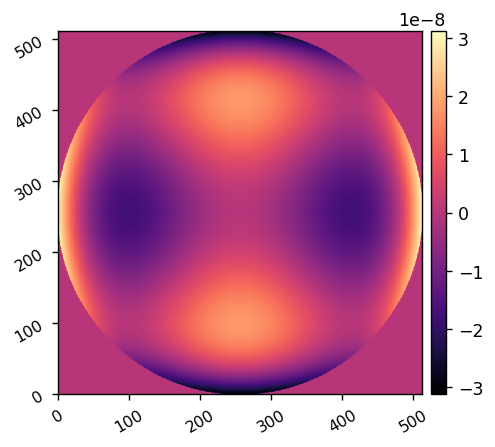

In [32]:
model.RETRIEVED = poppy.ArrayOpticalElement(opd=zmodes[8]*1e-8, pixelscale=model.pupil_diam/(model.npix*u.pix))
imshow1(model.RETRIEVED.opd)

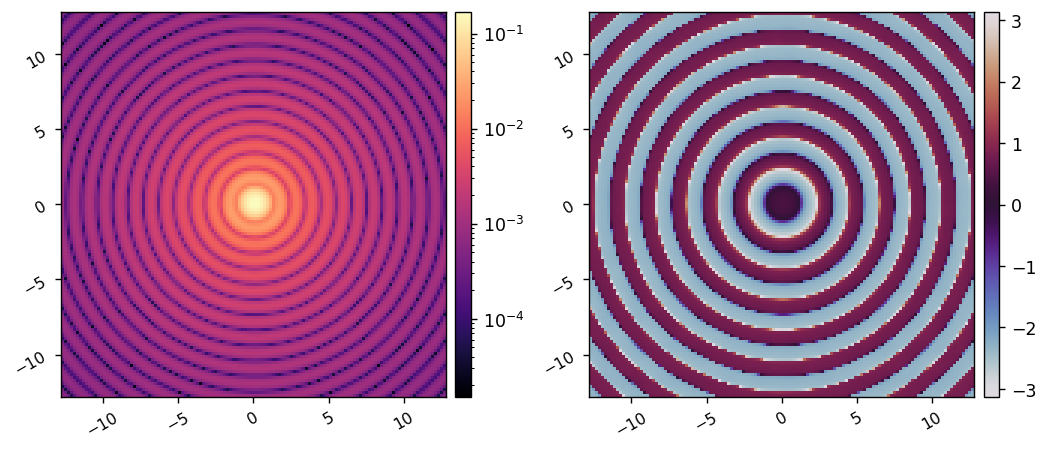

In [17]:
model.npsf = 128
imwf = model.calc_wf(plot=True)

In [41]:
reload(scoob)
model = scoob.SCOOBM()

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


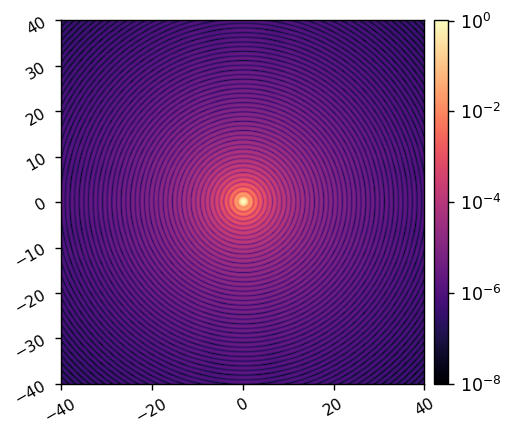

In [42]:
model.Imax_ref = model.snap().max()
ref_psf = model.snap(plot=True, vmin=1e-8)

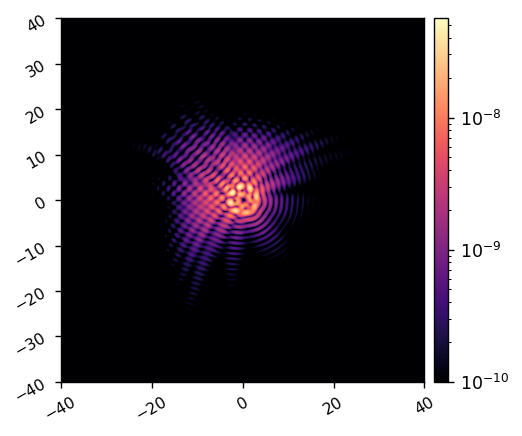

In [48]:
model.FPM = vortex
model.LYOT = lyot_stop

model.npix = 512
model.oversample = 8

ref_im = model.snap(plot=True, vmin=1e-10)

In [ ]:
lyot

In [33]:
reload(scoob)
model = scoob.SCOOBM()

model.npix = 256
model.oversample = 32

model.use_llowfsc = True
model.llowfsc_defocus = 2.5*u.mm
model.nllowfsc = 64

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


In [131]:
256*32

8192

In [35]:
model.FPM = vortex
model.LYOT = wfs_lyot_stop


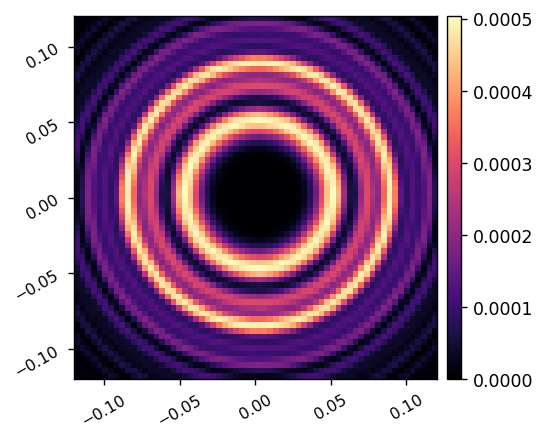

In [36]:
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))

In [ ]:
imshow

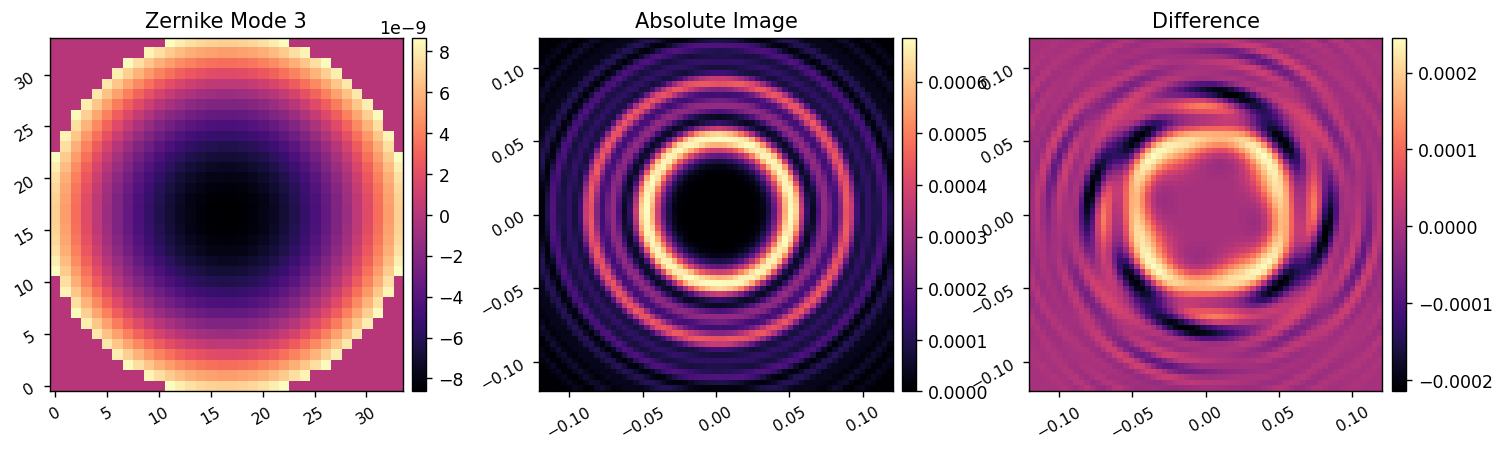

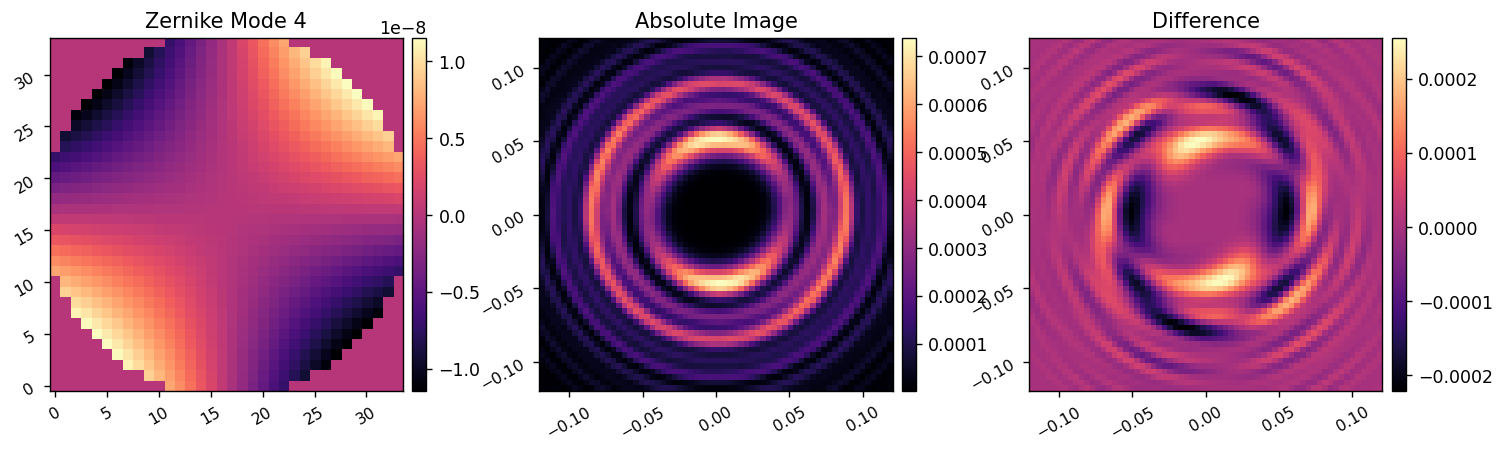

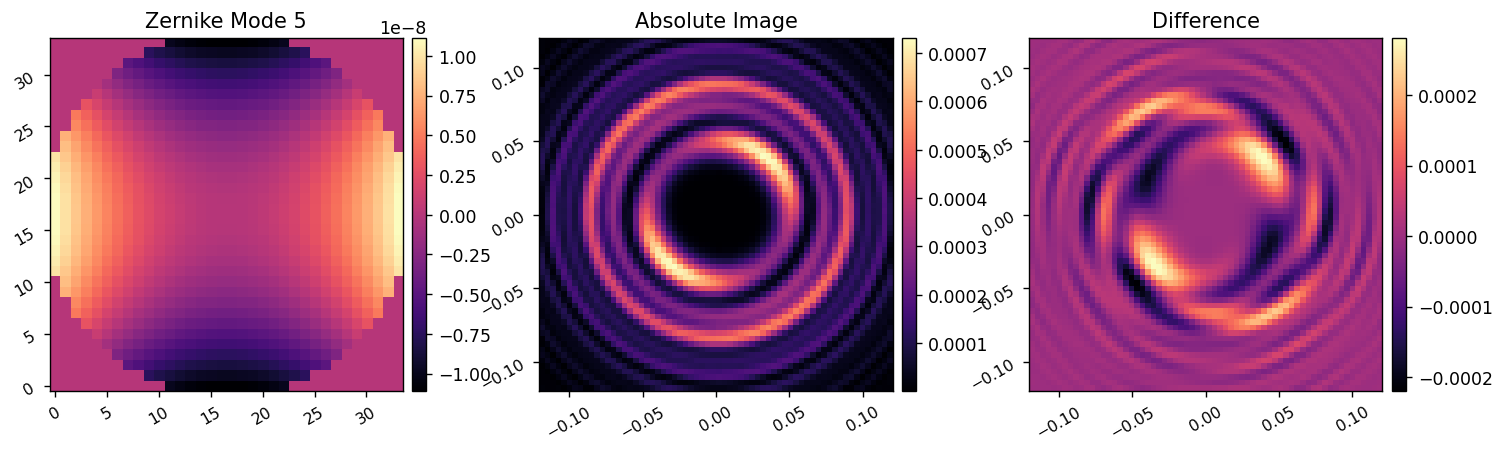

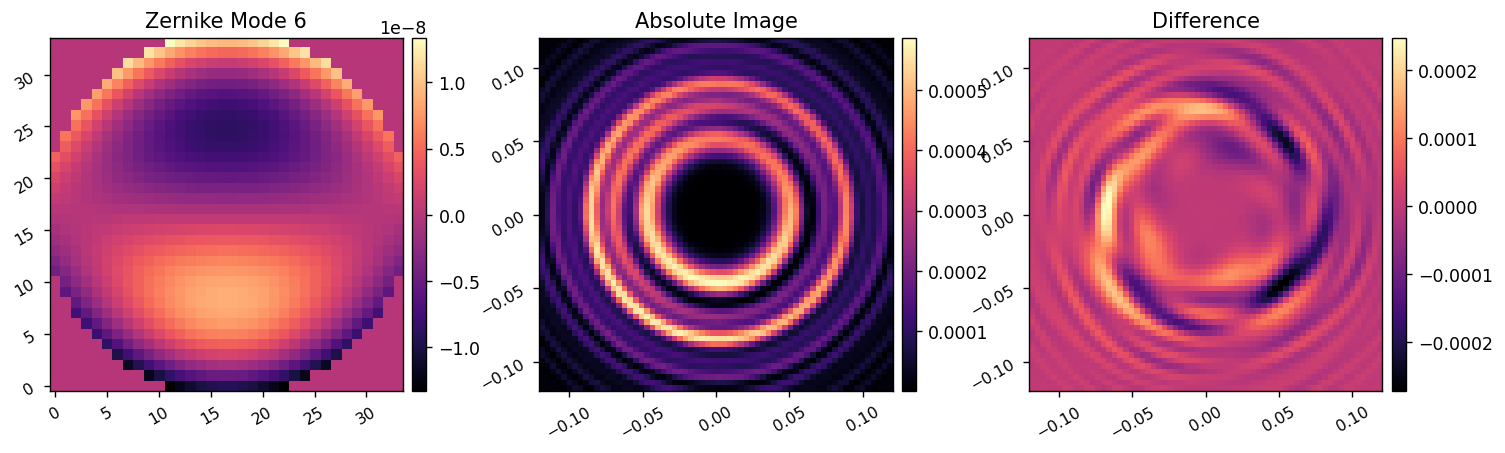

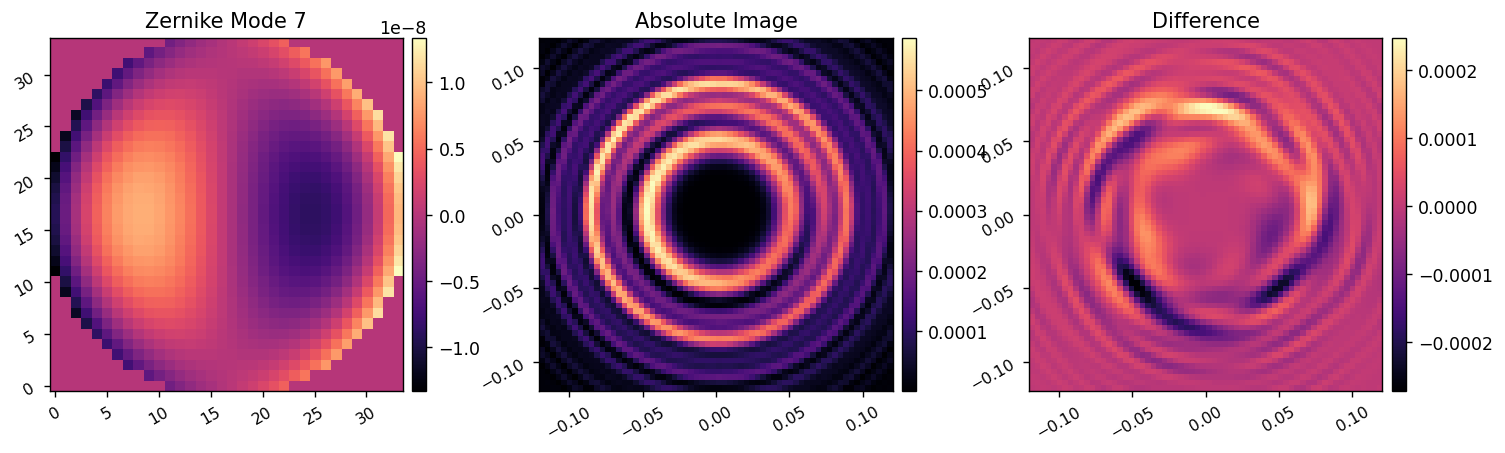

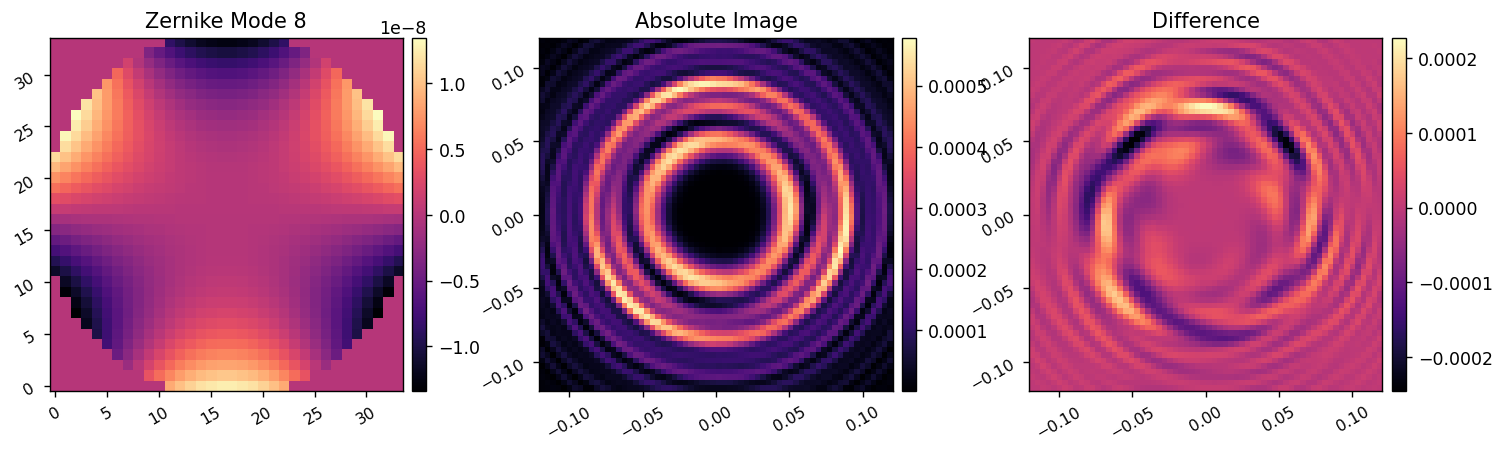

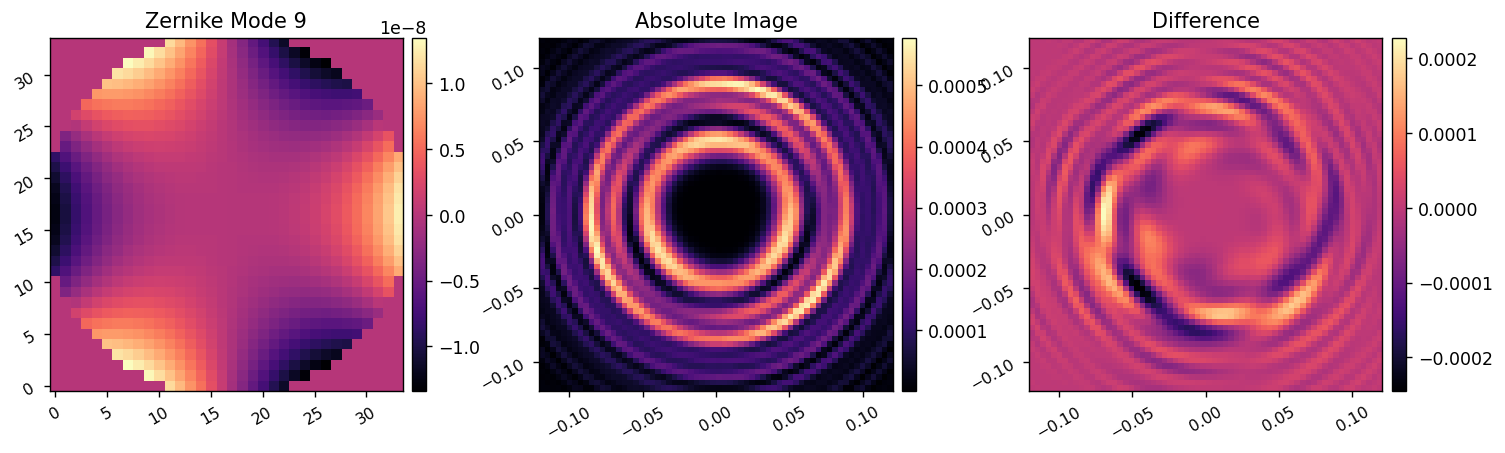

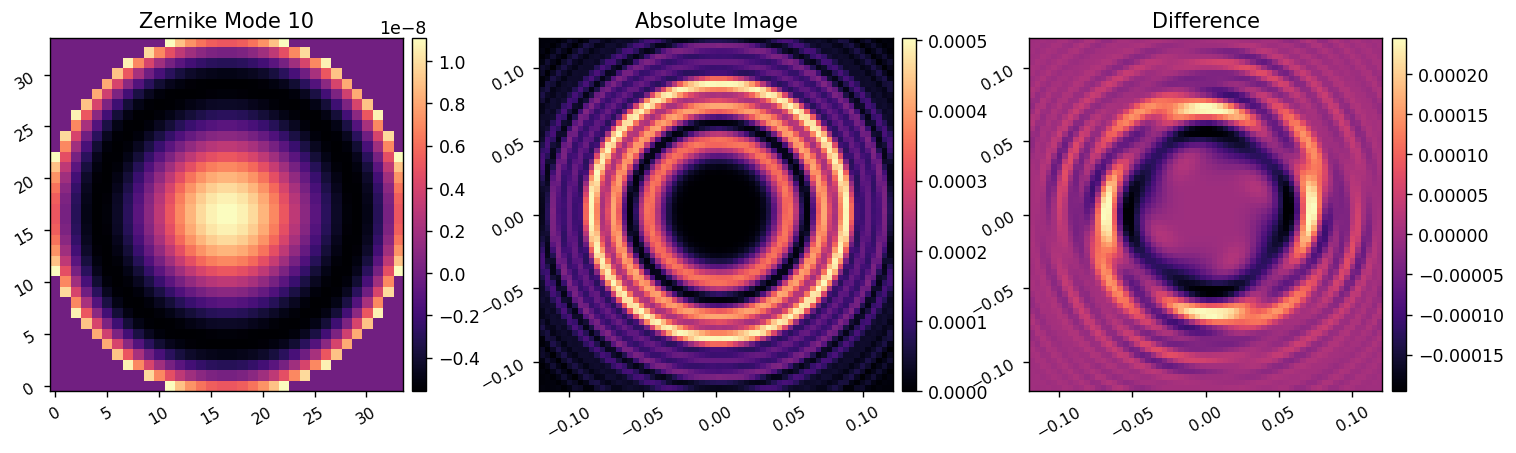

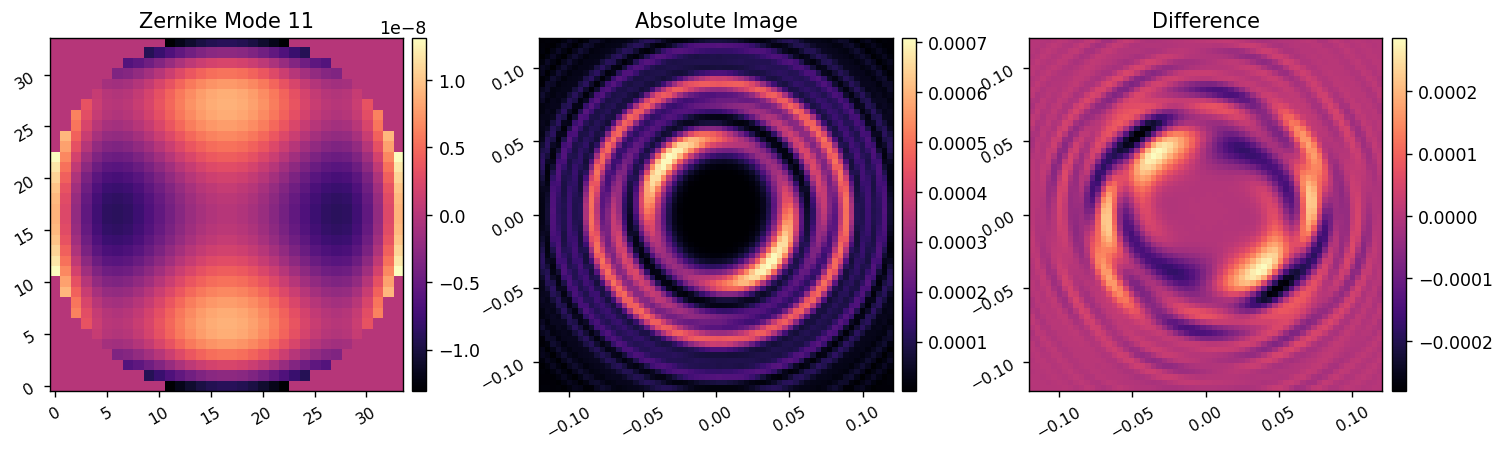

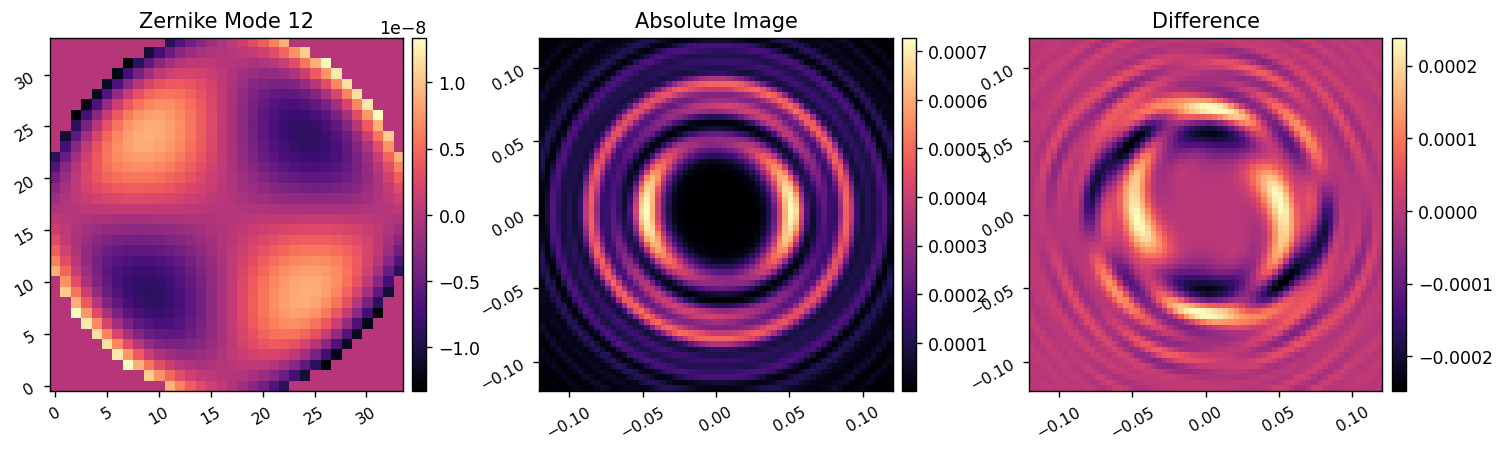

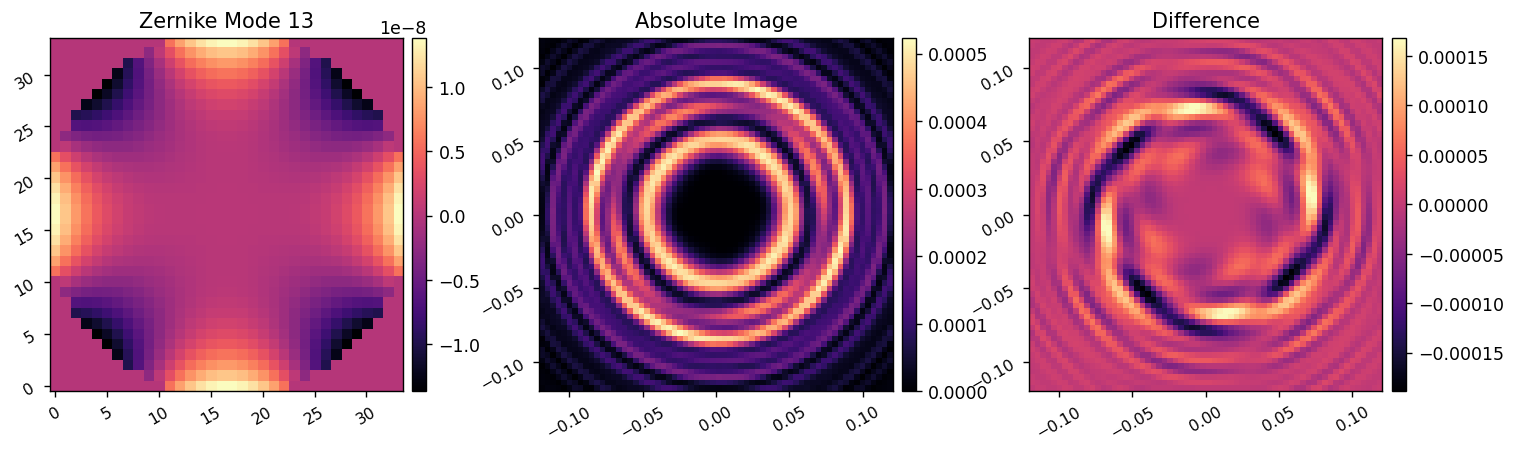

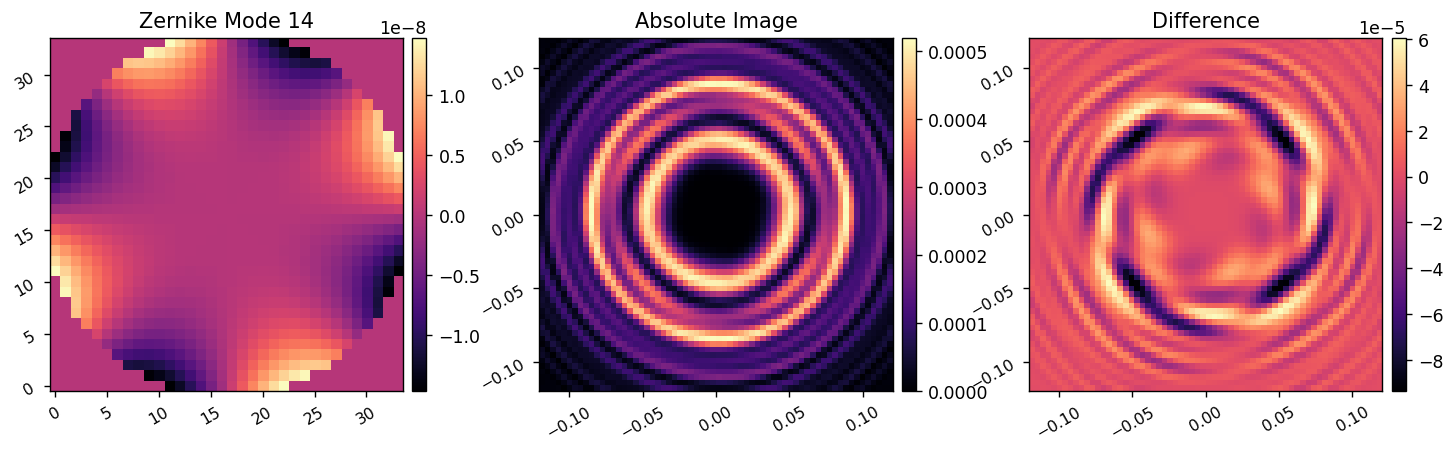

In [41]:
amp = 5e-9

im_ref = model.snap()

responses = xp.zeros((dm_zernikes.shape[0], model.nllowfsc, model.nllowfsc))
for i,mode in enumerate(dm_zernikes):
    model.set_dm(amp*mode)
    im_pos = model.snap()

    # model.add_dm(-2*amp*mode)
    # im_neg = model.snap()

    model.add_dm(amp*mode)
    diff = im_pos-im_ref

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+3}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix))

    responses[i] = diff/amp

In [113]:
wfs = model.calc_wfs()

Propagating wavelength 632.800 nm.
PSF calculated in 0.307s


In [ ]:
agpm = 

In [116]:
wfs[0].shape

(4096, 4096)

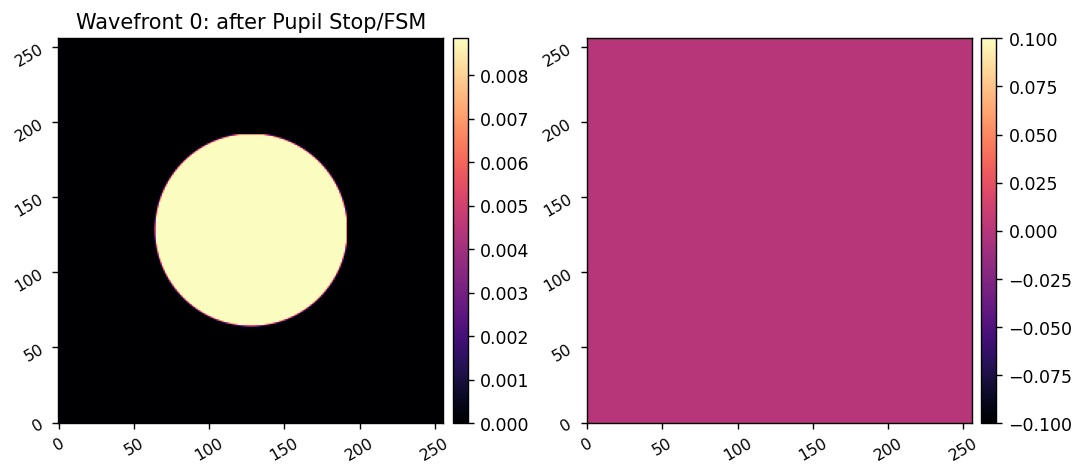

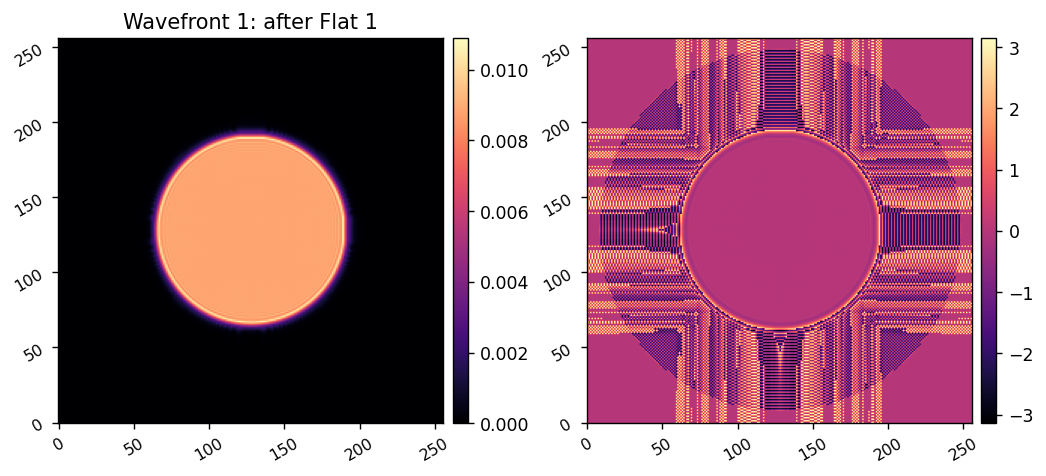

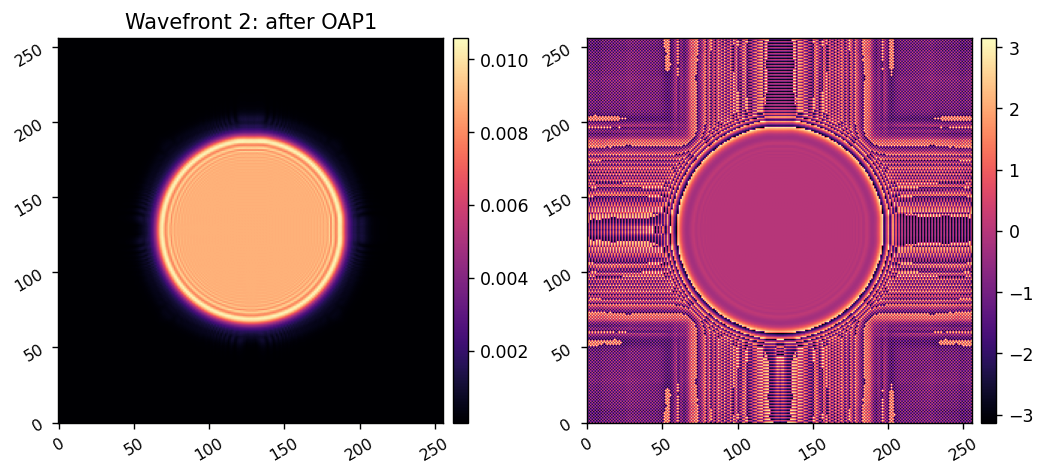

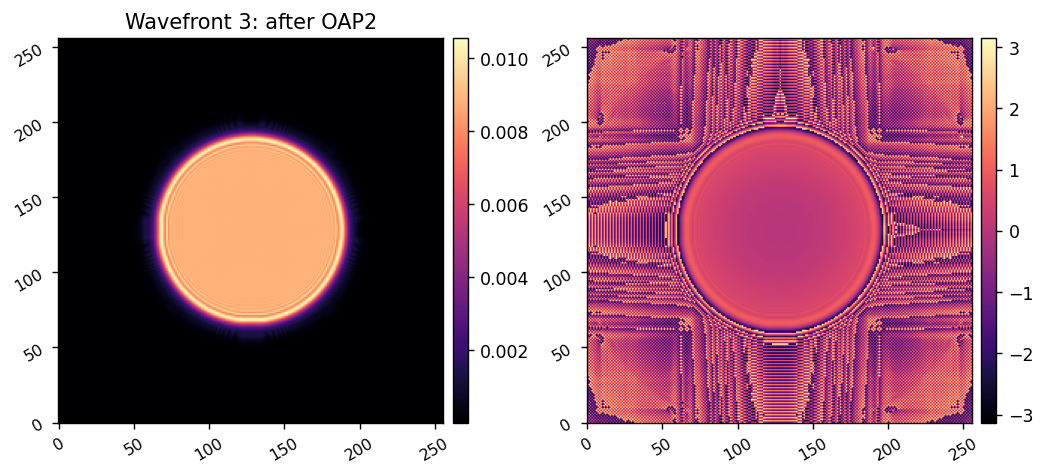

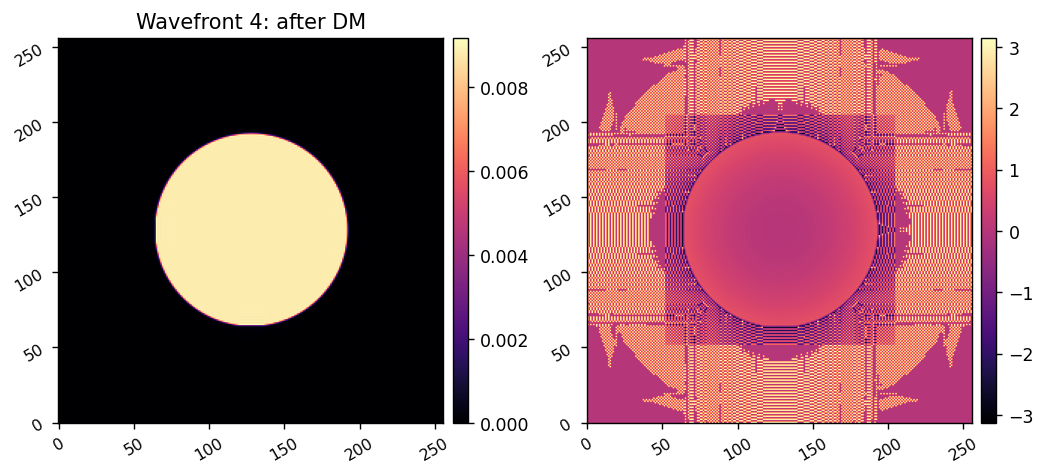

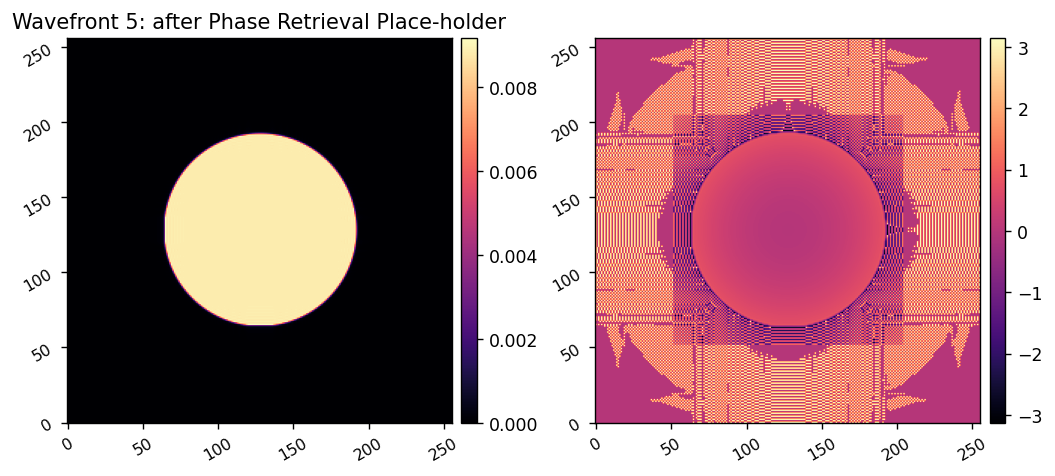

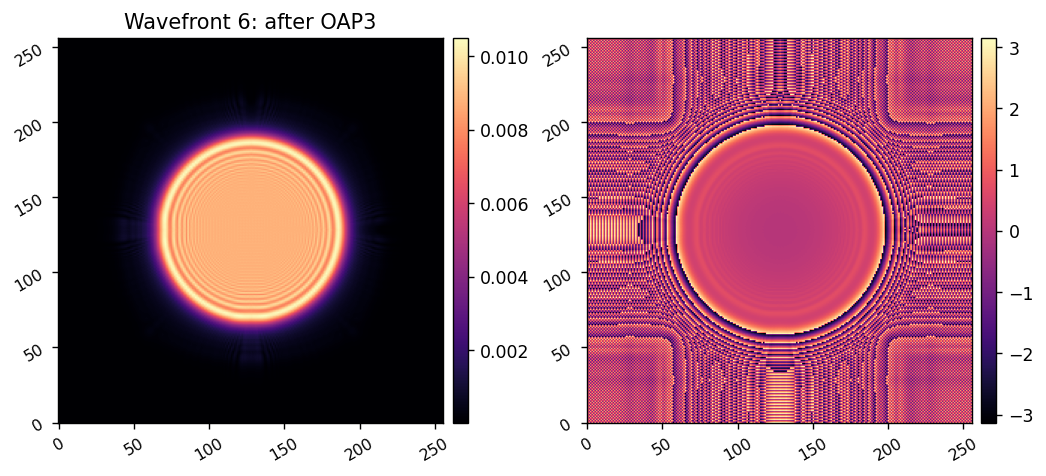

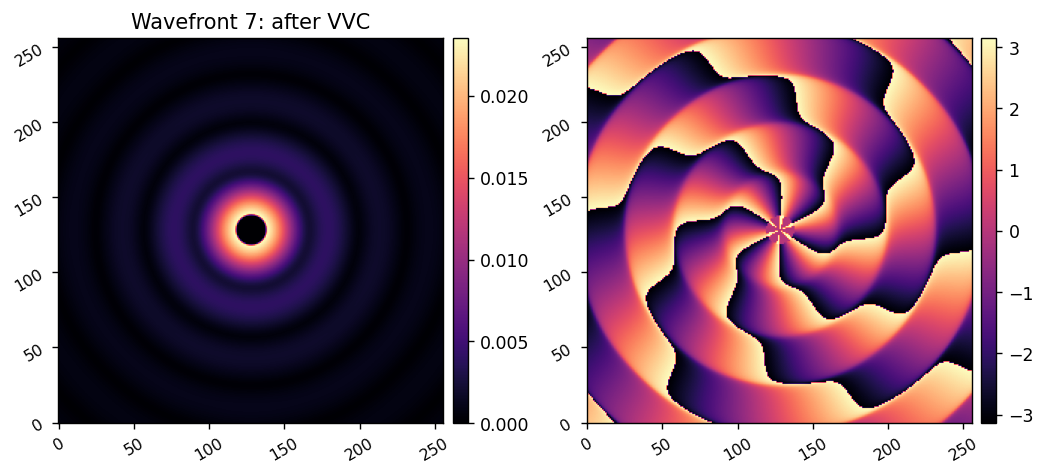

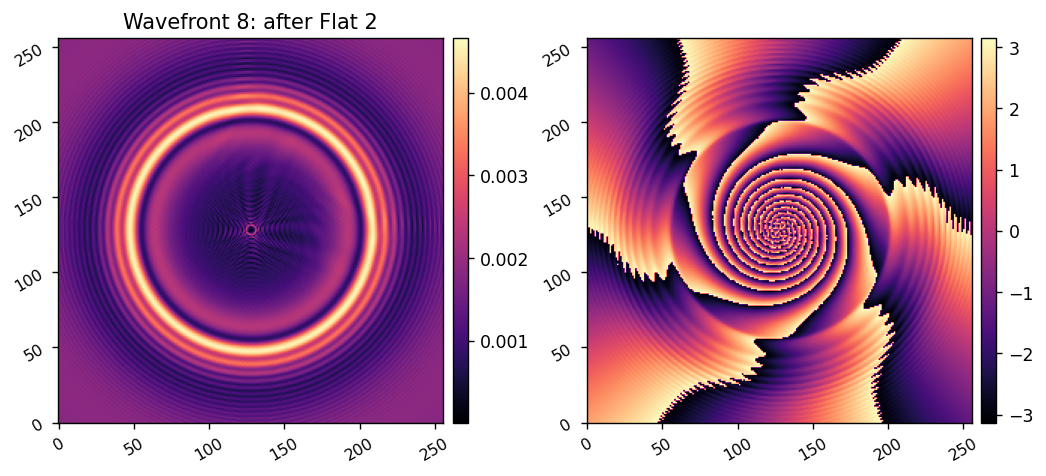

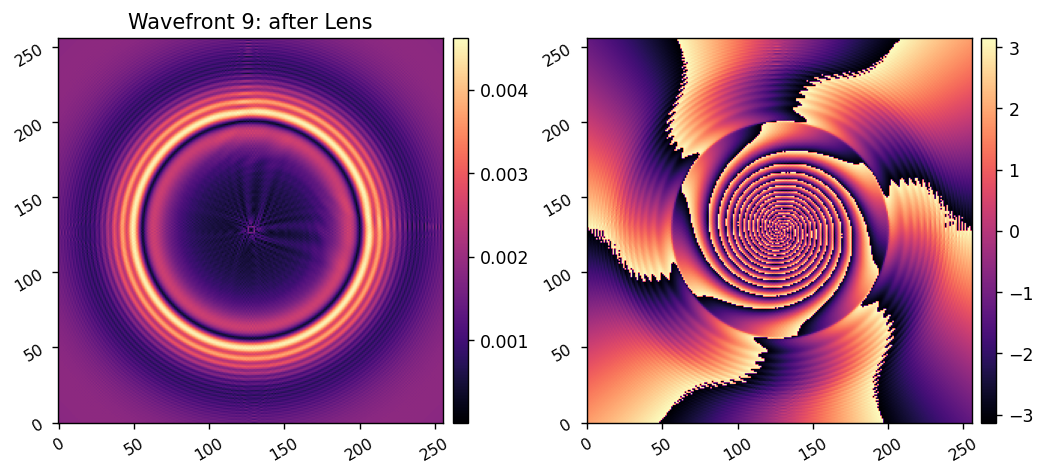

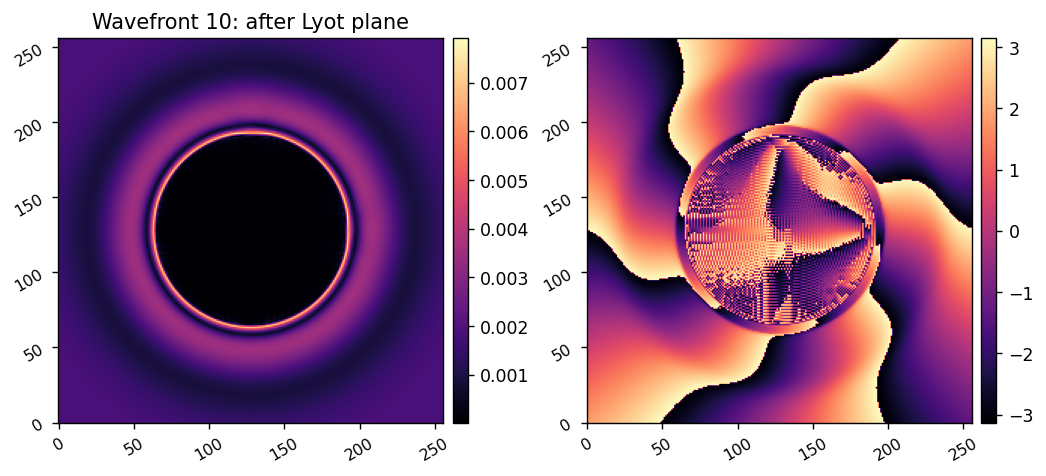

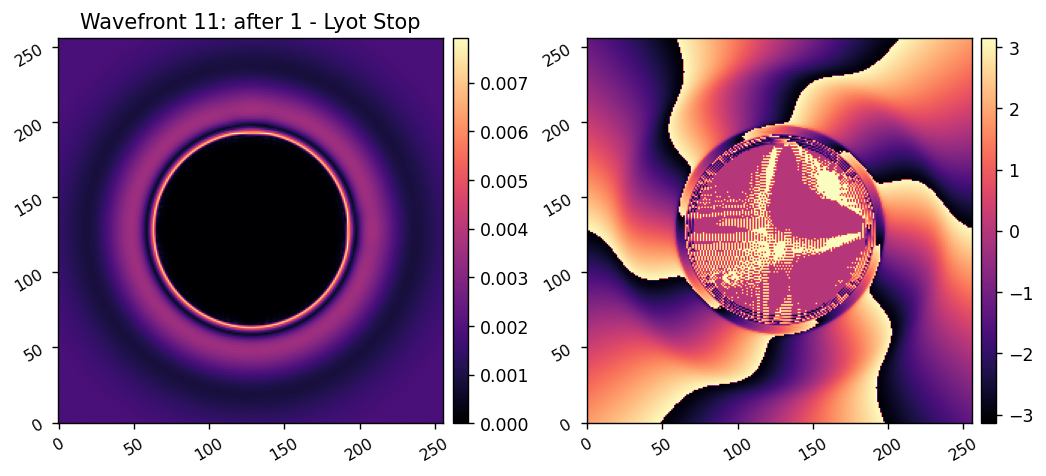

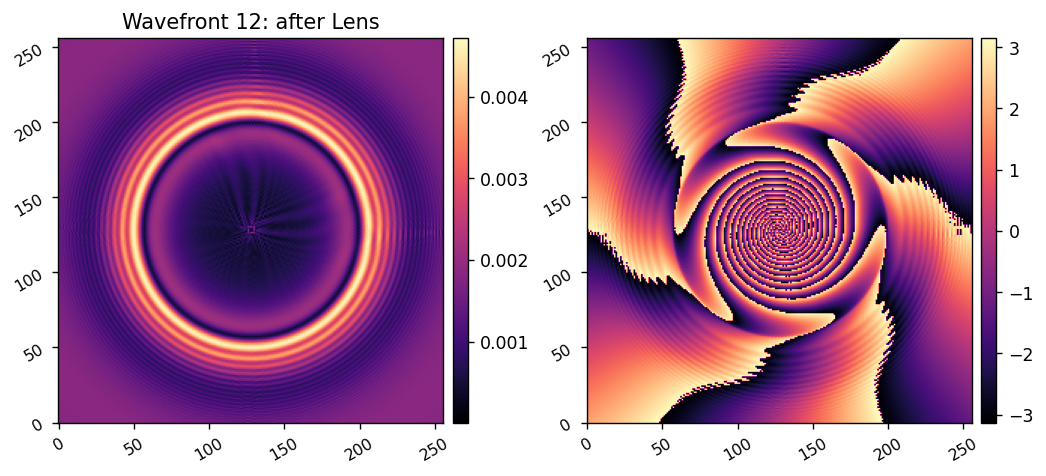

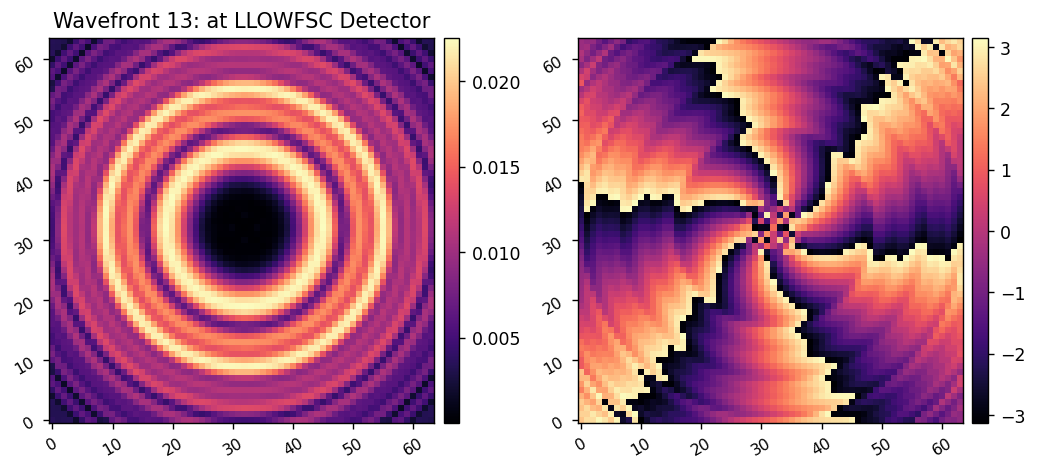

In [117]:
for i in range(len(wfs)):
    if 'focal plane' in wfs[i].location.lower() or 'detector' in wfs[i].location.lower():
        npix = wfs[i].shape[0]
    else:
        npix = 2*model.npix
    imshow2(wfs[i].amplitude, wfs[i].phase, f'Wavefront {i}: ' + wfs[i].location, npix=npix)
    